In [28]:
# GBM
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier  #GBM algorithm
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search


train = pd.read_csv('Microsoft-Malware-Challenge/Dataset/train/LargeTrain.csv')
test = pd.read_csv('Microsoft-Malware-Challenge/Dataset/test/LargeTest.csv')
target = 'Class'
IDcol = 'loc'

predictors = [x for x in train.columns if x not in [target, IDcol]]
param_test1 = {'n_estimators':list(range(20,81,10))}
my_scorer = metrics.make_scorer(metrics.f1_score, average="weighted")
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.3, min_samples_split=500,min_samples_leaf=50,max_depth=8,max_features='sqrt',subsample=0.8,random_state=10),
param_grid = param_test1, scoring=my_scorer,n_jobs=10,iid=False, cv=5)
gsearch1.fit(train[predictors],train[target])

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.3, loss='deviance', max_depth=8,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=50,
              min_samples_split=500, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=10,
              subsample=0.8, verbose=0, warm_start=False),
       fit_params={}, iid=False, n_jobs=10,
       param_grid={'n_estimators': [20, 30, 40, 50, 60, 70, 80]},
       pre_dispatch='2*n_jobs', refit=True,
       scoring=make_scorer(f1_score, average=weighted), verbose=0)

In [5]:
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.99454, std: 0.00118, params: {'n_estimators': 20},
  mean: 0.99491, std: 0.00078, params: {'n_estimators': 30},
  mean: 0.99547, std: 0.00107, params: {'n_estimators': 40},
  mean: 0.99510, std: 0.00129, params: {'n_estimators': 50},
  mean: 0.99510, std: 0.00153, params: {'n_estimators': 60},
  mean: 0.99511, std: 0.00152, params: {'n_estimators': 70},
  mean: 0.99520, std: 0.00137, params: {'n_estimators': 80}],
 {'n_estimators': 40},
 0.9954689867746994)

In [34]:
# 170531 heatmap
#import numpy as np
#import numpy.random
import matplotlib.pyplot as plt


scores = [x[1] for x in gsearch1.grid_scores_]
n_ests = [x for x in gsearch1.cv_results_['params']]

print "scores: ",scores
print "n_ests: ",n_ests


# Generate some test data
# x = np.array(range(20,81,10))
# y = np.random.randn(8873)

# heatmap, xedges, yedges = np.histogram2d(x, y, bins=50)
# extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

# plt.clf()
# plt.imshow(heatmap.T, extent=extent, origin='lower')
# plt.show()


AttributeError: 'GridSearchCV' object has no attribute 'cv_results_'

In [47]:
# XGBoost
import xgboost as xgb
import pandas as pd
import csv
import numpy as np
%pwd
path = 'Microsoft-Malware-Challenge/Dataset/train/LargeTrain.csv'
test_path = 'Microsoft-Malware-Challenge/Dataset/test/LargeTest.csv'

# with open(path, 'rb') as csvfile:
#     spamreader = csv.reader(csvfile)
#     for row in spamreader:
#         print ', '.join(row)
#         break
from numpy import genfromtxt
ori_train_data = genfromtxt(path, delimiter=',')
ori_test_data = genfromtxt(test_path, delimiter=',')


#
#
#


label_index = 692
my_data = ori_train_data
test_data = ori_test_data



data =  np.ndarray(shape=(len(my_data),1804), dtype=float, order='C')

f_train = []
f_test = []
    
f_index = 692


for i in range(len(my_data)):
    if i == 0:
        continue
    data[i] = np.delete(my_data[i], len(my_data[i])-1)
    f_train.append(data[i][label_index])

for i in range(len(test_data)):
    f_test.append(test_data[i][label_index])

f_train.sort()
f_test.sort()

#
#
#

label = np.zeros(len(data))


for i in range(len(data)):
    if data[i][f_index] > f_train[len(f_train)/2]:
        label[i] = 1 
        
# for i in range(len(test_data)):
#     if test_data[i][f_index] > f_test[len(f_test)/2]:
#         label[i] = 1

dtrain = xgb.DMatrix(data, label=label)
dtest = xgb.DMatrix(test_data,label=label)

In [59]:
import time
start_time = time.time()

from sklearn.model_selection import GridSearchCV
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import StratifiedKFold

seed = 5
n_fold_inner = 5
skf_inner = StratifiedKFold(n_splits=n_fold_inner,random_state=seed, shuffle=True)

fixed_parameters = {
               'max_depth':36,
               'min_child_weight':5,
               'learning_rate':0.4,
               'colsample_bytree':0.6,
               'subsample':0.2,
               'gamma':0,
               'max_delta_step':0,
               'colsample_bylevel':1,
               'reg_alpha':0,
               'reg_lambda':1,
               'scale_pos_weight':1,
               'base_score':0.6,
               'random_state':10,
               'objective':'binary:logistic',
               'silent': 1}

params_grid = {
               'n_estimators':np.linspace(1, 20, 20).astype('int')
               }

bst_grid = GridSearchCV(
            estimator=XGBClassifier(**fixed_parameters),param_grid=params_grid,n_jobs=8,
            cv=skf_inner,scoring='roc_auc',iid=False,refit=False,verbose=1)

bst_grid.fit(data,label)

best_params_grid_search = bst_grid.best_params_
best_score_grid_search = bst_grid.best_score_


means_train = bst_grid.cv_results_['mean_train_score']
stds_train = bst_grid.cv_results_['std_train_score']
means_test = bst_grid.cv_results_['mean_test_score']
stds_test = bst_grid.cv_results_['std_test_score']

print("--- %s seconds ---" % (time.time() - start_time))

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/usr/local/lib/python2.7/dist-packages/xgboost-0.6-py2.7.egg/xgboost/sklearn.py:161: DeprecationWarning:

The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.

/usr/local/lib/python2.7/dist-packages/xgboost-0.6-py2.7.egg/xgboost/sklearn.py:171: DeprecationWarning:

The nthread parameter is deprecated as of version .6.Please use n_jobs instead.nthread is deprecated.

/usr/local/lib/python2.7/dist-packages/xgboost-0.6-py2.7.egg/xgboost/sklearn.py:161: DeprecationWarning:

The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.

/usr/local/lib/python2.7/dist-packages/xgboost-0.6-py2.7.egg/xgboost/sklearn.py:171: DeprecationWarning:

The nthread parameter is deprecated as of version .6.Please use n_jobs instead.nthread is deprecated.

/usr/local/lib/python2.7/dist-packages/xgboost-0.6-py2.7.egg/xgboost/sklearn.py:161: DeprecationWarning:

The seed parameter is deprecated as of version .6.Please u

/usr/local/lib/python2.7/dist-packages/xgboost-0.6-py2.7.egg/xgboost/sklearn.py:161: DeprecationWarning:

The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.

/usr/local/lib/python2.7/dist-packages/xgboost-0.6-py2.7.egg/xgboost/sklearn.py:171: DeprecationWarning:

The nthread parameter is deprecated as of version .6.Please use n_jobs instead.nthread is deprecated.

/usr/local/lib/python2.7/dist-packages/xgboost-0.6-py2.7.egg/xgboost/sklearn.py:161: DeprecationWarning:

The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.

/usr/local/lib/python2.7/dist-packages/xgboost-0.6-py2.7.egg/xgboost/sklearn.py:171: DeprecationWarning:

The nthread parameter is deprecated as of version .6.Please use n_jobs instead.nthread is deprecated.

/usr/local/lib/python2.7/dist-packages/xgboost-0.6-py2.7.egg/xgboost/sklearn.py:161: DeprecationWarning:

The seed parameter is deprecated as of version .6.Please u

/usr/local/lib/python2.7/dist-packages/xgboost-0.6-py2.7.egg/xgboost/sklearn.py:161: DeprecationWarning:

The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.

/usr/local/lib/python2.7/dist-packages/xgboost-0.6-py2.7.egg/xgboost/sklearn.py:171: DeprecationWarning:

The nthread parameter is deprecated as of version .6.Please use n_jobs instead.nthread is deprecated.

/usr/local/lib/python2.7/dist-packages/xgboost-0.6-py2.7.egg/xgboost/sklearn.py:161: DeprecationWarning:

The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.

/usr/local/lib/python2.7/dist-packages/xgboost-0.6-py2.7.egg/xgboost/sklearn.py:171: DeprecationWarning:

The nthread parameter is deprecated as of version .6.Please use n_jobs instead.nthread is deprecated.

/usr/local/lib/python2.7/dist-packages/xgboost-0.6-py2.7.egg/xgboost/sklearn.py:161: DeprecationWarning:

The seed parameter is deprecated as of version .6.Please u

/usr/local/lib/python2.7/dist-packages/xgboost-0.6-py2.7.egg/xgboost/sklearn.py:161: DeprecationWarning:

The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.

/usr/local/lib/python2.7/dist-packages/xgboost-0.6-py2.7.egg/xgboost/sklearn.py:171: DeprecationWarning:

The nthread parameter is deprecated as of version .6.Please use n_jobs instead.nthread is deprecated.

/usr/local/lib/python2.7/dist-packages/xgboost-0.6-py2.7.egg/xgboost/sklearn.py:161: DeprecationWarning:

The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.

/usr/local/lib/python2.7/dist-packages/xgboost-0.6-py2.7.egg/xgboost/sklearn.py:171: DeprecationWarning:

The nthread parameter is deprecated as of version .6.Please use n_jobs instead.nthread is deprecated.

/usr/local/lib/python2.7/dist-packages/xgboost-0.6-py2.7.egg/xgboost/sklearn.py:161: DeprecationWarning:

The seed parameter is deprecated as of version .6.Please u

/usr/local/lib/python2.7/dist-packages/xgboost-0.6-py2.7.egg/xgboost/sklearn.py:161: DeprecationWarning:

The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.

/usr/local/lib/python2.7/dist-packages/xgboost-0.6-py2.7.egg/xgboost/sklearn.py:171: DeprecationWarning:

The nthread parameter is deprecated as of version .6.Please use n_jobs instead.nthread is deprecated.

/usr/local/lib/python2.7/dist-packages/xgboost-0.6-py2.7.egg/xgboost/sklearn.py:161: DeprecationWarning:

The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.

/usr/local/lib/python2.7/dist-packages/xgboost-0.6-py2.7.egg/xgboost/sklearn.py:171: DeprecationWarning:

The nthread parameter is deprecated as of version .6.Please use n_jobs instead.nthread is deprecated.

/usr/local/lib/python2.7/dist-packages/xgboost-0.6-py2.7.egg/xgboost/sklearn.py:161: DeprecationWarning:

The seed parameter is deprecated as of version .6.Please u

/usr/local/lib/python2.7/dist-packages/xgboost-0.6-py2.7.egg/xgboost/sklearn.py:161: DeprecationWarning:

The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.

/usr/local/lib/python2.7/dist-packages/xgboost-0.6-py2.7.egg/xgboost/sklearn.py:171: DeprecationWarning:

The nthread parameter is deprecated as of version .6.Please use n_jobs instead.nthread is deprecated.



--- 70.5467381477 seconds ---


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.2min finished



test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0.823220306362 0.00730486463466 0.823220251152 0.00182625976415
0.886919232385 0.0101511660409 0.888120170454 0.0027621905488
0.906289934312 0.00855029748622 0.906513623219 0.00435378667146
0.931128341333 0.00590618186279 0.933080457313 0.00412944192031
0.931128341333 0.00590618186279 0.933080457313 0.00412944192031
0.931128341333 0.00590618186279 0.933080457313 0.00412944192031
0.931128341333 0.00590618186279 0.933080457313 0.00412944192031
0.931128341333 0.00590618186279 0.933080457313 0.00412944192031
0.931128341333 0.00590618186279 0.933080457313 0.00412944192031
0.931128341333 0.00590618186279 0.933080457313 0.00412944192031
0.931128341333 0.00590618186279 0.933080457313 0.00412944192031
0.931128341333 0.00590618186279 0.933080457313 0.00412944192031
0.931128341333 0.00590618186279 0.933080457313 0.00412944192031
0.931128341333 0.00590618186279 0.933080457313 0.00412944192031
0.931128341333 0.00590618186279 0.933080457313

/usr/local/lib/python2.7/dist-packages/seaborn/matrix.py:143: DeprecationWarning:

elementwise == comparison failed; this will raise an error in the future.

/usr/local/lib/python2.7/dist-packages/seaborn/matrix.py:151: DeprecationWarning:

elementwise == comparison failed; this will raise an error in the future.



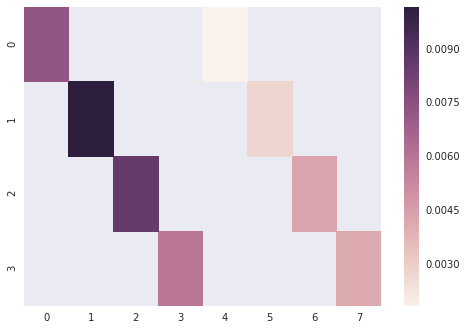

/usr/local/lib/python2.7/dist-packages/seaborn/matrix.py:143: DeprecationWarning:

elementwise == comparison failed; this will raise an error in the future.

/usr/local/lib/python2.7/dist-packages/seaborn/matrix.py:151: DeprecationWarning:

elementwise == comparison failed; this will raise an error in the future.



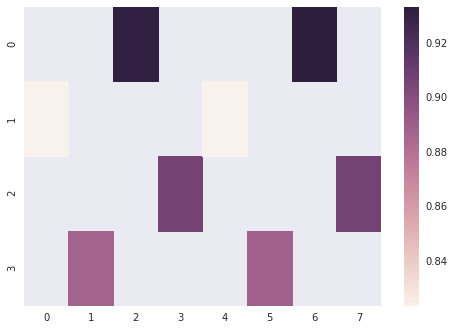

In [56]:
# 'min_child_weight':500, 'learning_rate':0.4,
print('\ntest-auc-mean  test-auc-std  train-auc-mean  train-auc-std')
for idx in range(0, len(means_test)):
    print means_test[idx], stds_test[idx], means_train[idx], stds_train[idx]

rows = []
for idx in range(0, len(means_test)):
    rows.append((means_test[idx], stds_test[idx], means_train[idx], stds_train[idx]))

df = pd.DataFrame(rows)
df.columns = ('test-auc-mean', 'test-auc-std', 'train-auc-mean', 'train-auc-std')

import seaborn
from seaborn import plt
source_perf = pd.pivot_table(df[['test-auc-mean', 'test-auc-std', 'train-auc-mean', 'train-auc-std']], columns=['train-auc-mean'], index=['test-auc-mean'])
seaborn.heatmap(np.array(source_perf))
plt.show()

target_perf = pd.pivot_table(df[['test-auc-mean', 'test-auc-std', 'train-auc-mean', 'train-auc-std']], columns=['train-auc-std'], index=['test-auc-std'])
seaborn.heatmap(np.array(target_perf))
plt.show()


test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0.93202598303 0.0233035780914 0.957999202455 0.0122524171687
0.999717009854 0.000174095234567 0.999933652162 3.17674794454e-05
0.999726157798 0.000159014441202 0.99994481749 3.10506309965e-05
0.999564460498 0.000227115055351 0.999911479755 5.09602056886e-05
0.999451011586 0.000286389916385 0.999893873519 5.81818373639e-05
0.999925671402 4.81954936333e-05 0.999996005993 3.7565574662e-06
0.999988263906 1.19514535021e-05 1.0 7.02166693715e-17
0.999979135832 1.81627643421e-05 0.999999755469 3.26041417065e-07
1.0 0.0 1.0 4.96506830649e-17
1.0 0.0 1.0 4.96506830649e-17
1.0 0.0 1.0 4.96506830649e-17
1.0 0.0 1.0 0.0
1.0 0.0 1.0 0.0
1.0 0.0 1.0 0.0
1.0 0.0 1.0 0.0
1.0 0.0 1.0 4.96506830649e-17
1.0 0.0 1.0 4.96506830649e-17
1.0 4.96506830649e-17 1.0 1.31363359814e-16
1.0 4.96506830649e-17 1.0 4.96506830649e-17
1.0 0.0 1.0 4.96506830649e-17


/usr/local/lib/python2.7/dist-packages/seaborn/matrix.py:143: DeprecationWarning:

elementwise == comparison failed; this will raise an error in the future.

/usr/local/lib/python2.7/dist-packages/seaborn/matrix.py:151: DeprecationWarning:

elementwise == comparison failed; this will raise an error in the future.



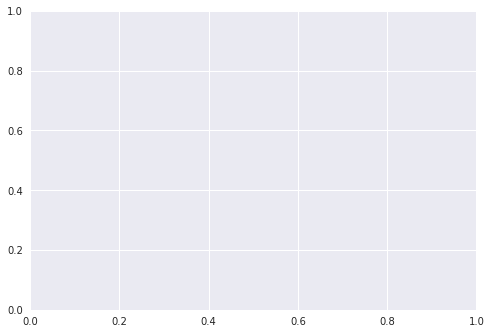

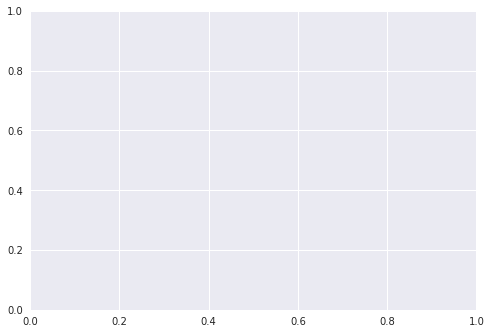

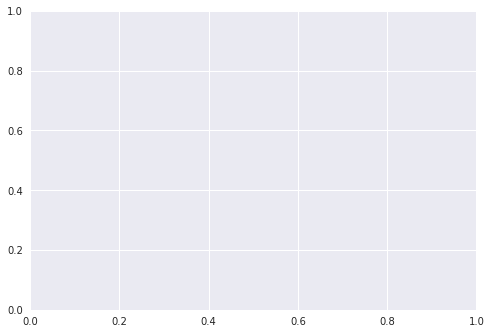

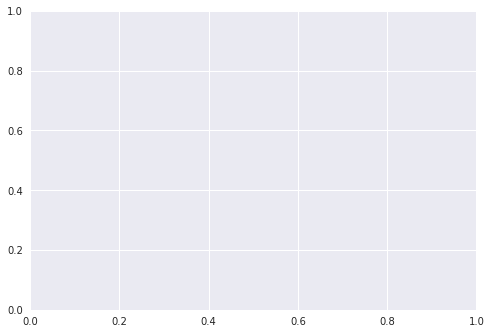

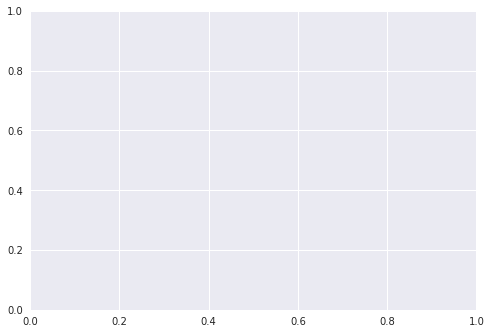

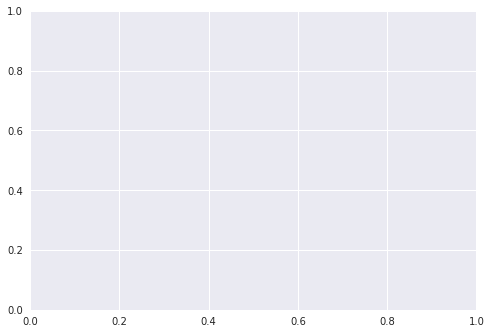

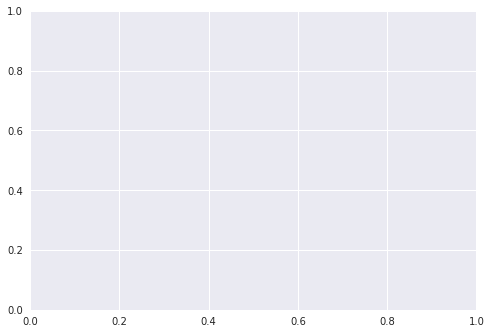

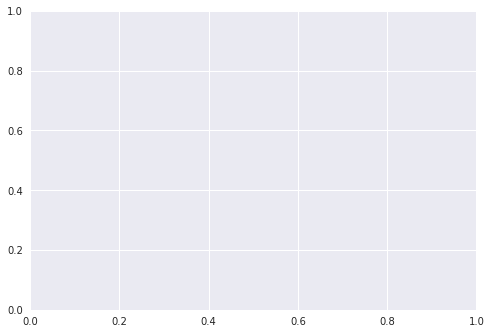

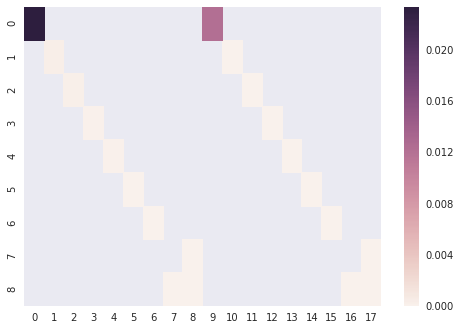

/usr/local/lib/python2.7/dist-packages/seaborn/matrix.py:143: DeprecationWarning:

elementwise == comparison failed; this will raise an error in the future.

/usr/local/lib/python2.7/dist-packages/seaborn/matrix.py:151: DeprecationWarning:

elementwise == comparison failed; this will raise an error in the future.



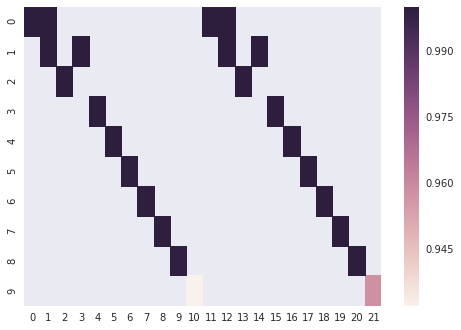

In [51]:
# 'min_child_weight':5, 'learning_rate':0.4,
print('\ntest-auc-mean  test-auc-std  train-auc-mean  train-auc-std')
for idx in range(0, len(means_test)):
    print means_test[idx], stds_test[idx], means_train[idx], stds_train[idx]

rows = []
for idx in range(0, len(means_test)):
    rows.append((means_test[idx], stds_test[idx], means_train[idx], stds_train[idx]))

df = pd.DataFrame(rows)
df.columns = ('test-auc-mean', 'test-auc-std', 'train-auc-mean', 'train-auc-std')

import seaborn
from seaborn import plt
source_perf = pd.pivot_table(df[['test-auc-mean', 'test-auc-std', 'train-auc-mean', 'train-auc-std']], columns=['train-auc-mean'], index=['test-auc-mean'])
seaborn.heatmap(np.array(source_perf))
plt.show()

target_perf = pd.pivot_table(df[['test-auc-mean', 'test-auc-std', 'train-auc-mean', 'train-auc-std']], columns=['train-auc-std'], index=['test-auc-std'])
seaborn.heatmap(np.array(target_perf))
plt.show()


test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0.917267917647 0.0279443727603 0.936977710863 0.0207042331781
0.999748292445 0.000140385450903 0.999856955148 5.76412645225e-05
0.999505780026 0.000291801302188 0.999798017342 0.00011159258693
0.999981743853 2.27361996886e-05 1.0 0.0
1.0 0.0 1.0 0.0
1.0 0.0 1.0 0.0
0.999997391979 5.21604193695e-06 1.0 4.96506830649e-17
1.0 0.0 1.0 4.96506830649e-17
1.0 0.0 1.0 4.96506830649e-17
1.0 0.0 1.0 4.96506830649e-17
1.0 0.0 1.0 4.96506830649e-17
1.0 0.0 1.0 4.96506830649e-17
1.0 0.0 1.0 4.96506830649e-17
1.0 0.0 1.0 4.96506830649e-17
1.0 4.96506830649e-17 1.0 0.0
1.0 9.93013661299e-17 1.0 0.0
1.0 4.96506830649e-17 1.0 4.96506830649e-17
1.0 0.0 1.0 7.02166693715e-17
1.0 4.96506830649e-17 1.0 4.96506830649e-17
1.0 0.0 1.0 4.96506830649e-17


/usr/local/lib/python2.7/dist-packages/seaborn/matrix.py:143: DeprecationWarning:

elementwise == comparison failed; this will raise an error in the future.

/usr/local/lib/python2.7/dist-packages/seaborn/matrix.py:151: DeprecationWarning:

elementwise == comparison failed; this will raise an error in the future.



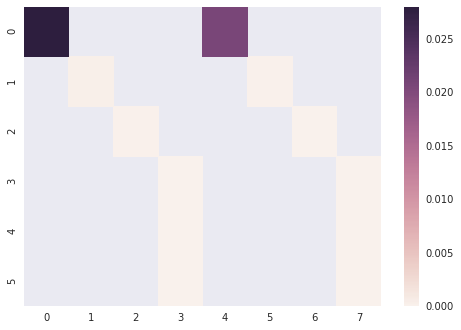

/usr/local/lib/python2.7/dist-packages/seaborn/matrix.py:143: DeprecationWarning:

elementwise == comparison failed; this will raise an error in the future.

/usr/local/lib/python2.7/dist-packages/seaborn/matrix.py:151: DeprecationWarning:

elementwise == comparison failed; this will raise an error in the future.



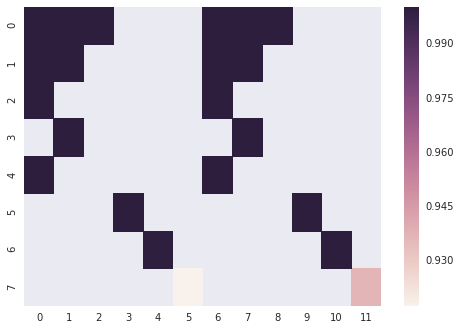

In [58]:
# 'min_child_weight':5, 'learning_rate':0.4, 'subsample':0.5,
print('\ntest-auc-mean  test-auc-std  train-auc-mean  train-auc-std')
for idx in range(0, len(means_test)):
    print means_test[idx], stds_test[idx], means_train[idx], stds_train[idx]

rows = []
for idx in range(0, len(means_test)):
    rows.append((means_test[idx], stds_test[idx], means_train[idx], stds_train[idx]))

df = pd.DataFrame(rows)
df.columns = ('test-auc-mean', 'test-auc-std', 'train-auc-mean', 'train-auc-std')

import seaborn
from seaborn import plt
source_perf = pd.pivot_table(df[['test-auc-mean', 'test-auc-std', 'train-auc-mean', 'train-auc-std']], columns=['train-auc-mean'], index=['test-auc-mean'])
seaborn.heatmap(np.array(source_perf))
plt.show()

target_perf = pd.pivot_table(df[['test-auc-mean', 'test-auc-std', 'train-auc-mean', 'train-auc-std']], columns=['train-auc-std'], index=['test-auc-std'])
seaborn.heatmap(np.array(target_perf))
plt.show()


test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0.920661664234 0.0320613870057 0.924851207024 0.0262032985423
0.999804398427 0.000264170768249 0.999900394347 0.000123356597081
0.999591844718 0.000296231462137 0.999745606184 0.00016667470352
1.0 0.0 1.0 0.0
1.0 0.0 1.0 0.0
1.0 0.0 1.0 0.0
1.0 0.0 1.0 4.96506830649e-17
1.0 0.0 1.0 4.96506830649e-17
1.0 0.0 1.0 0.0
1.0 0.0 1.0 0.0
1.0 0.0 1.0 0.0
1.0 0.0 1.0 0.0
1.0 4.96506830649e-17 1.0 7.02166693715e-17
1.0 0.0 1.0 0.0
1.0 0.0 1.0 9.93013661299e-17
1.0 0.0 1.0 1.11022302463e-16
1.0 0.0 1.0 1.11022302463e-16
1.0 0.0 1.0 1.11022302463e-16
1.0 0.0 1.0 9.93013661299e-17
1.0 0.0 1.0 9.93013661299e-17


/usr/local/lib/python2.7/dist-packages/seaborn/matrix.py:143: DeprecationWarning:

elementwise == comparison failed; this will raise an error in the future.

/usr/local/lib/python2.7/dist-packages/seaborn/matrix.py:151: DeprecationWarning:

elementwise == comparison failed; this will raise an error in the future.



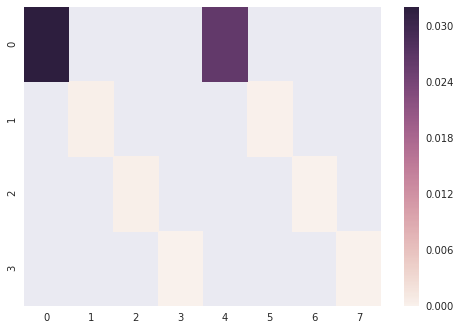

/usr/local/lib/python2.7/dist-packages/seaborn/matrix.py:143: DeprecationWarning:

elementwise == comparison failed; this will raise an error in the future.

/usr/local/lib/python2.7/dist-packages/seaborn/matrix.py:151: DeprecationWarning:

elementwise == comparison failed; this will raise an error in the future.



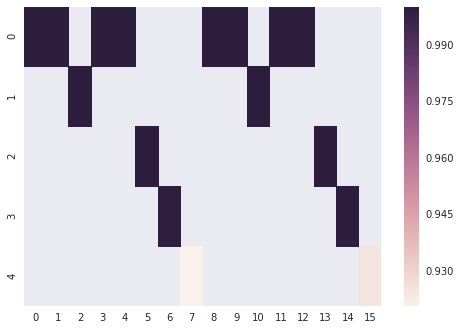

In [61]:
# 'min_child_weight':5, 'learning_rate':0.4, 'subsample':0.2,
print('\ntest-auc-mean  test-auc-std  train-auc-mean  train-auc-std')
for idx in range(0, len(means_test)):
    print means_test[idx], stds_test[idx], means_train[idx], stds_train[idx]

rows = []
for idx in range(0, len(means_test)):
    rows.append((means_test[idx], stds_test[idx], means_train[idx], stds_train[idx]))

df = pd.DataFrame(rows)
df.columns = ('test-auc-mean', 'test-auc-std', 'train-auc-mean', 'train-auc-std')

import seaborn
from seaborn import plt
source_perf = pd.pivot_table(df[['test-auc-mean', 'test-auc-std', 'train-auc-mean', 'train-auc-std']], columns=['train-auc-mean'], index=['test-auc-mean'])
seaborn.heatmap(np.array(source_perf))
plt.show()

target_perf = pd.pivot_table(df[['test-auc-mean', 'test-auc-std', 'train-auc-mean', 'train-auc-std']], columns=['train-auc-std'], index=['test-auc-std'])
seaborn.heatmap(np.array(target_perf))
plt.show()